In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

cv09_bunkyB = cv2.imread("cv09_bunkyB.bmp", cv2.IMREAD_GRAYSCALE)
cv09_bunkyC = cv2.imread("cv09_bunkyC.bmp", cv2.IMREAD_GRAYSCALE)
cv09_rice = cv2.imread("cv09_rice.bmp", cv2.IMREAD_GRAYSCALE)

# def dilation(img, kernel = np.array([[0, 1, 0],
#                                        [1, 1, 1]], np.uint8)):
#     """
#     param img: input image
#     param kernel: kernel is stuctural element
#     """
#     img_dilation = np.zeros(img.shape, np.uint8)
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if i > 1 and j > 1 and i < img.shape[0] - 1 and j < img.shape[1] - 1 :
#                 img_dilation[i, j] = np.max(img[i-1:i+1, j-1:j+2] * kernel)
#     return img_dilation

# return cv2.dilate(img, kernel, iterations=1)


def dilation(img, kernel=np.array([[0, 1, 0], [1, 1, 1]], np.uint8)):
    # Create an empty output image
    output = np.zeros_like(img)

    # Pad the input image with zeros
    img_padded = np.pad(img, ((1, 1), (1, 1)), mode="constant", constant_values=0)

    # Loop over the pixels of the input image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Compute the maximum pixel value under the kernel
            max_val = -np.inf
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    if kernel[k, l] != 0:
                        val = img_padded[i + k, j + l] + kernel[k, l]
                        if val > max_val:
                            max_val = val
            output[i, j] = max_val

    return output


# def erosion(img, kernel=np.array([[0, 1, 0], [1, 1, 1]], np.uint8)):
#     """
#     param img: input image
#     """
#     img_erosion = np.zeros(img.shape, np.uint8)
#     for i in range(img.shape[0] + 1):
#         for j in range(img.shape[1] + 1):
#             if i < img.shape[0] - 1 and j < img.shape[1] - 2:
#                 img_erosion[i, j] = np.max(img[i : i + 2, j : j + 3] * -kernel)
#     np.invert(img_erosion, img_erosion)
#     return img_erosion
#     # return cv2.erode(img, kernel, iterations=1)


def erosion(img, kernel=np.array([[0, 1, 0], [1, 1, 1]], np.uint8)):
    # Create an empty output image
    output = np.zeros_like(img)

    # Pad the input image with zeros
    img_padded = np.pad(img, ((1, 1), (1, 1)), mode="constant", constant_values=0)

    # Loop over the pixels of the input image
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Compute the minimum pixel value under the kernel
            min_val = np.inf
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    if kernel[k, l] != 0:
                        val = img_padded[i + k, j + l] - kernel[k, l]
                        if val < min_val:
                            min_val = val
            output[i, j] = min_val

    return output


def opening(img, kernel):
    """
    param img: input image
    """
    # first erosion, then dilation
    img_opening = erosion(img, kernel)
    img_opening = dilation(img_opening, kernel)
    return img_opening


def closing(img, kernel):
    """ """
    # first dilation, then erosion
    img_closing = dilation(img, kernel)
    img_closing = erosion(img_closing, kernel)
    return img_closing


def img_to_gray(img):
    """
    param img: input image
    return: gray image
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def top_hat(img, kernel):
    """
    param img: input image
    """
    # img to uint8
    img_top_hat = cv2.morphologyEx(img.astype(np.uint16), cv2.MORPH_TOPHAT, kernel)
    return img_top_hat


def image_color_segmentation(img, threshold):
    """
    param img: input image

    """
    # extract the color channels
    img = img.astype(np.uint8)
    background = img

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if background[i, j] >= threshold:
                img[i, j] = 0
            else:
                img[i, j] = 255

    return img


class ColorSpace:
    def __init__(self):
        self.pixel_value = 0
        self.color_value = 0


def region_coloring(img):
    """
    region identification and coloring

    """
    # tmp_img = np.zeros_like(gray_img, dtype=ColorSpace)
    tmp_img = [[ColorSpace() for i in range(img.shape[1])] for j in range(img.shape[0])]
    tmp_img = np.array(tmp_img)

    for i in range(tmp_img.shape[0]):
        for j in range(tmp_img.shape[1]):
            if img[i, j] != 0:
                tmp_img[i, j].pixel_value = 1
                tmp_img[i, j].color_value = 0

    uniqe_color_iterator = 1
    iter = 0
    while True:
        flag_changed_color = False
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > 0 and j > 0 and i < img.shape[0] - 1 and j < img.shape[1] - 1:
                    if tmp_img[i, j].pixel_value == 1:
                        mask = np.array(
                            [
                                tmp_img[i - 1, j - 1],
                                tmp_img[i - 1, j],
                                tmp_img[i - 1, j + 1],
                                tmp_img[i, j - 1],
                                tmp_img[i, j + 1],
                                tmp_img[i + 1, j - 1],
                                tmp_img[i + 1, j],
                                tmp_img[i + 1, j + 1],
                            ]
                        )

                        # get non black pixels from mask
                        color = [
                            x.color_value
                            for x in mask
                            if x.pixel_value == 1 and x.color_value != 0
                        ]

                        # if there is no non black pixel in mask
                        if len(color) == 0 and tmp_img[i, j].pixel_value == 1:
                            tmp_img[i, j].color_value = uniqe_color_iterator
                            uniqe_color_iterator += 1
                            flag_changed_color = True
                        elif (
                            tmp_img[i, j].pixel_value == 1
                            and min(color) != tmp_img[i, j].color_value
                        ):
                            tmp_img[i, j].color_value = min(color)
                            flag_changed_color = True
        iter += 1
        if flag_changed_color == False or iter > 20:
            break

    final_img = np.zeros_like(img, dtype=np.uint8)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tmp_img[i, j].pixel_value == 1:
                color = tmp_img[i, j].color_value
                final_img[i, j] = color
    print(np.unique(final_img))
    return final_img


def center_of_mass(img):
    centers = []
    for i in np.unique(img):
        mask = img == i
        y, x = np.where(mask)
        print(
            "Center of mass for region {}: ({:.2f}, {:.2f})".format(
                i, np.mean(x), np.mean(y)
            )
        )
        if i != 0:
            centers.append((np.mean(x), np.mean(y)))
    return centers

C:\Users\najma\AppData\Local\Temp\ipykernel_12416\2875623749.py:77: RuntimeWarning: overflow encountered in scalar subtract
  val = img_padded[i + k, j + l] - kernel[k, l]


Text(0.5, 1.0, 'closing cv09_bunkyC')

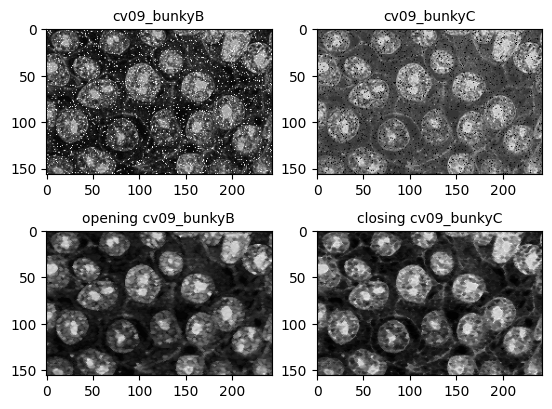

In [44]:
# 1.  Z obrázků cv09_bunkyB.bmp a cv09_bunkyC.bmp odstraňte drobný bílý 
# (černý)  šum  při  využití  šedotónových  morfologických  transformací 
# otevření a uzavření.  
 
# strukturní element volte:   [[0, 1, 0], 
#                  [1, 1, 1]] 

kernel = np.array([[0, 1, 0], [1, 1, 1]], np.uint8)
size_sub = 2

plt.figure()
plt.subplot(size_sub, 2, 1)
plt.imshow(cv09_bunkyB, cmap='gray')
plt.title('cv09_bunkyB', fontsize=10)

plt.subplot(size_sub, 2, 2)
plt.imshow(cv09_bunkyC, cmap='gray')
plt.title('cv09_bunkyC', fontsize=10)

plt.subplot(size_sub, 2, 3)
plt.imshow(opening(cv09_bunkyB, kernel), cmap='gray')
plt.title('opening cv09_bunkyB', fontsize=10)

plt.subplot(size_sub, 2, 4)
plt.imshow(closing(cv09_bunkyC, kernel), cmap='gray')
plt.title('closing cv09_bunkyC', fontsize=10)

Text(0.5, 1.0, 'histogram cv09_rice')

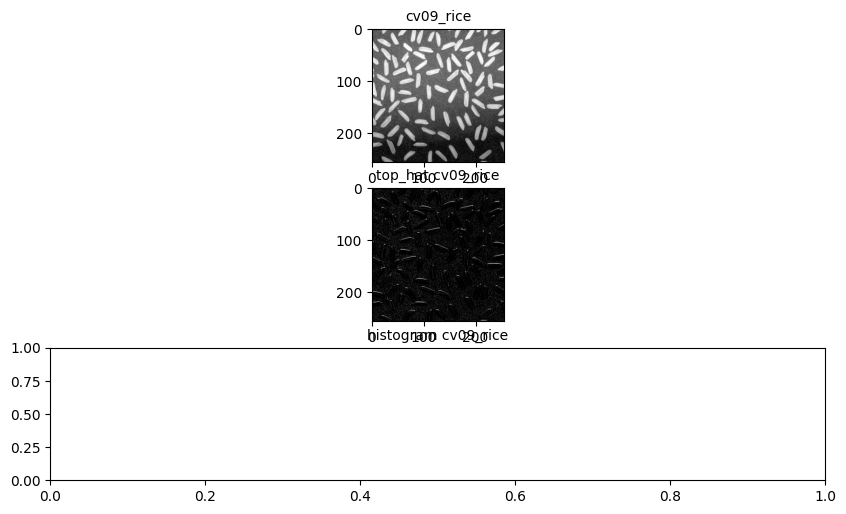

In [45]:
size_sub = 5
plt.figure(figsize=(10, 10))
plt.subplot(size_sub, 1, 1)
plt.imshow(cv09_rice, cmap='gray')
plt.title('cv09_rice', fontsize=10)

plt.subplot(size_sub, 1, 2)
rice_top_hat = top_hat(cv09_rice, kernel)
plt.imshow(rice_top_hat, cmap='gray')
plt.title('top_hat cv09_rice', fontsize=10)

plt.subplot(size_sub, 1, 3)
plt.title('histogram cv09_rice', fontsize=10)

# rice_segmentation = image_color_segmentation(rice_top_hat, 150)
# plt.subplot(size_sub, 1, 4)
# plt.imshow(rice_segmentation, cmap='gray')
# plt.title('segmentation cv09_rice', fontsize=10)

# plt.subplot(size_sub, 1, 5)
# plt.imshow(cv09_rice, cmap='gray')
# im1 = region_coloring(rice_segmentation)
# centers = center_of_mass(im1)
# plt.scatter([x for x, y in centers], [y for x, y in centers], c="g", s=50, marker="+")
